<a href="https://colab.research.google.com/github/Akkun-salsa/Optical-Flow-for-Angiography/blob/main/dence_optical_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Optical Flow Analysis from MR Angiography
---



# Refferensed Sight<br>
[Dense Optical Flowを矢印や色空間で表示する方法](https://qiita.com/yusuke_s_yusuke/items/03243490b1fd765fe61f)<br>


[Google Colab/Drive に pip インストール: これなら消えない](https://ggcs.io/2020/06/22/google-colab-pip-install/) <br>

[Pythonを使ってDICOMやNIfTIといった医療画像を読み込む](https://note.com/techguide_dl/n/n5e64a991ddd8)


# Google Driveとの連携

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 各種設定

In [2]:
# Download 'pydicom' at folder 'my-module'
!pip install --target '/content/drive/MyDrive/Colab\ Notebooks/my-modules'  pydicom
# 各種インポート
import cv2
import matplotlib.pyplot as plt
import numpy as np
# パッケージ読み込み
import glob
import os
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/my-modules')
import pydicom
import nibabel as nib
from scipy import ndimage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.6 MB/s eta 0:00:00


Make data folder and download sample nii file

In [3]:
# prompt: 'https://drive.google.com/file/d/1z70Z_IcnimTZZILuqv8Z-MU5cNyulRWG/view?usp=sharing'からファイルを'/content/data'フォルダにダウンロードする
%cd /content
os.makedirs('/content/data', exist_ok=True)
!gdown --output /content/data/file.nii https://drive.google.com/uc?id=1z70Z_IcnimTZZILuqv8Z-MU5cNyulRWG


/content
Downloading...
From: https://drive.google.com/uc?id=1z70Z_IcnimTZZILuqv8Z-MU5cNyulRWG
To: /content/data/file.nii
100% 48.2M/48.2M [00:00<00:00, 54.4MB/s]


Read NifTi file

In [4]:
data = nib.load('data/file.nii')
img_list = data.get_fdata()
print(img_list.shape)
print(data.shape)

(1024, 1024, 23)
(1024, 1024, 23)


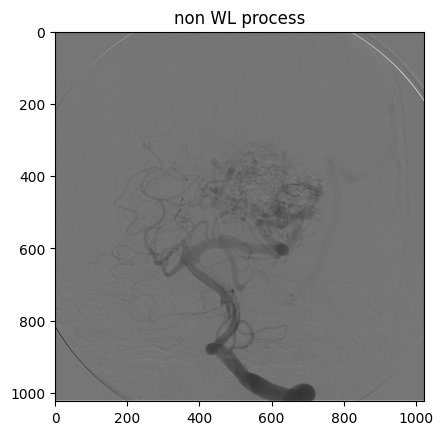

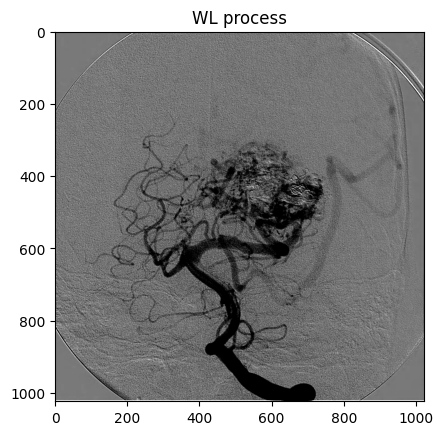

In [5]:
img = img_list[:,:,6]

img = ndimage.rotate(img, 90, reshape=False)
plt.title('non WL process')
plt.imshow(img, cmap='gray')
plt.show()

# ウィンドウ処理
w_max = 593
w_min = 417
img_w = 255*(img - w_min)/(w_max - w_min)
img_w[img_w > 255] = 255 # 255より大きいところを255にする
img_w[img_w < 0] = 0 # 0未満を0にする

plt.title('WL process')
plt.imshow(img_w, cmap='gray')
plt.show()
#cv2.imwrite('img15.png', img_w)

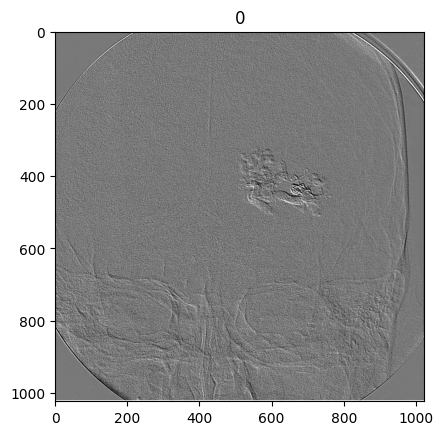

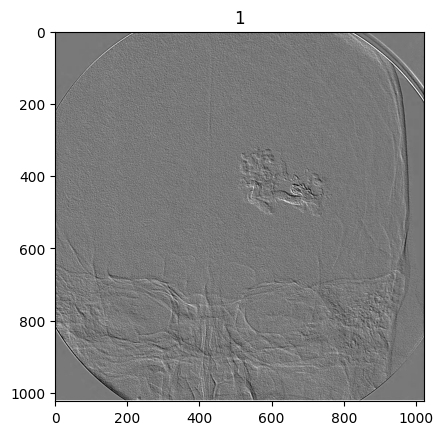

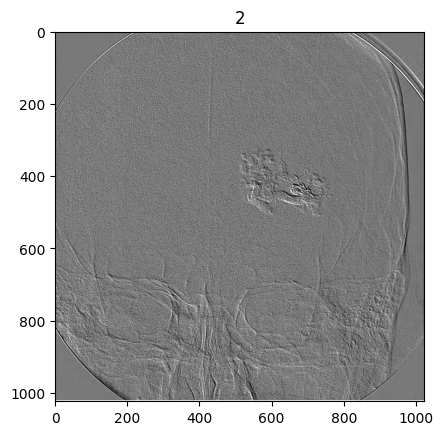

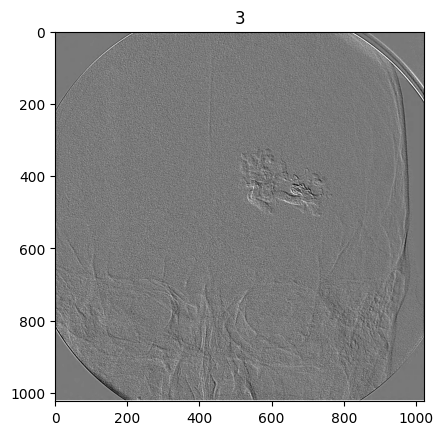

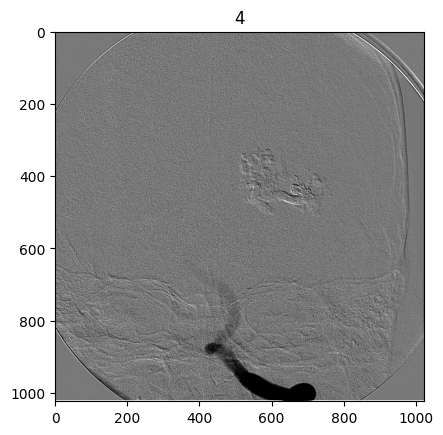

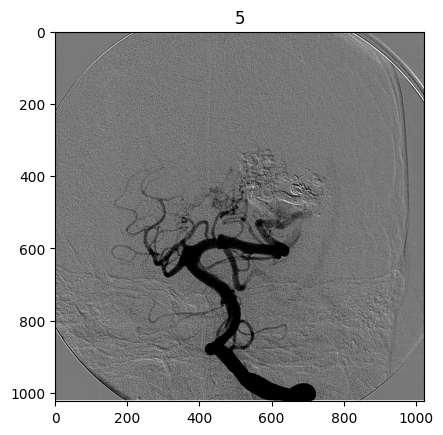

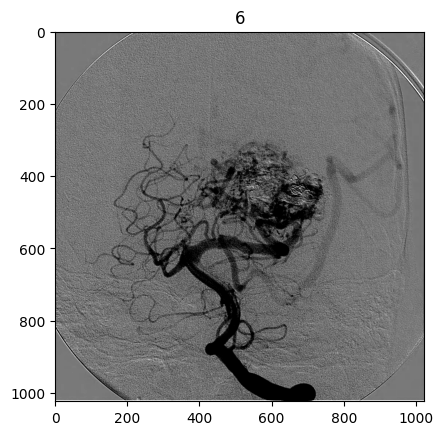

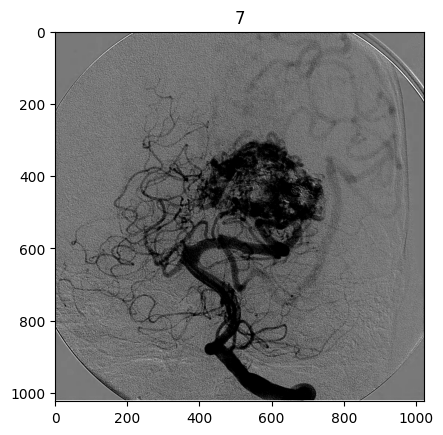

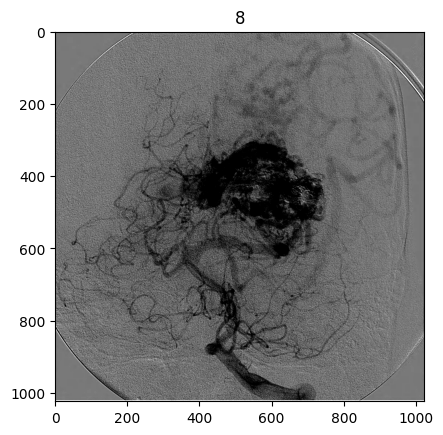

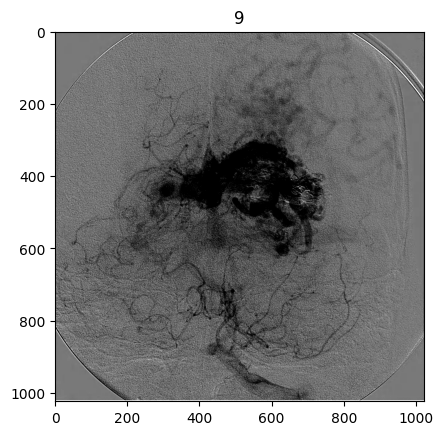

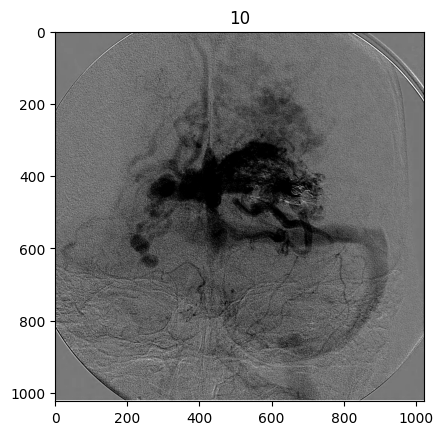

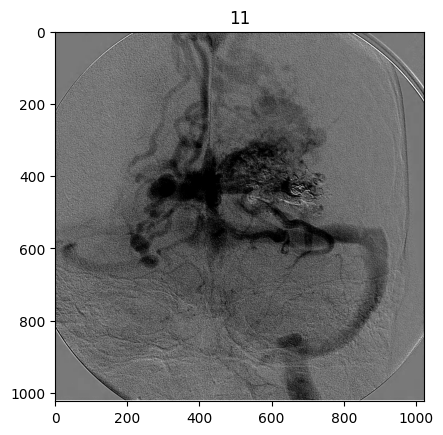

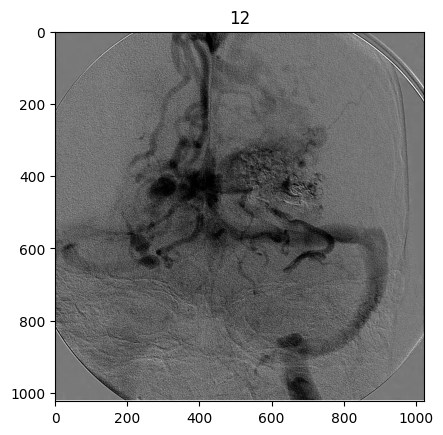

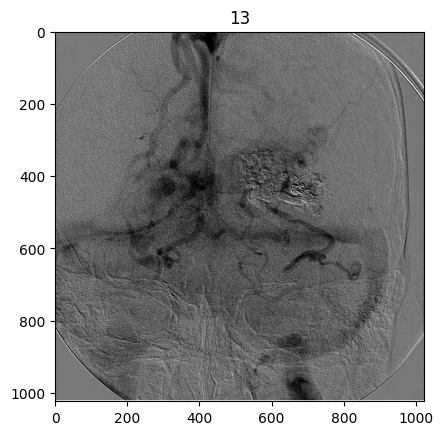

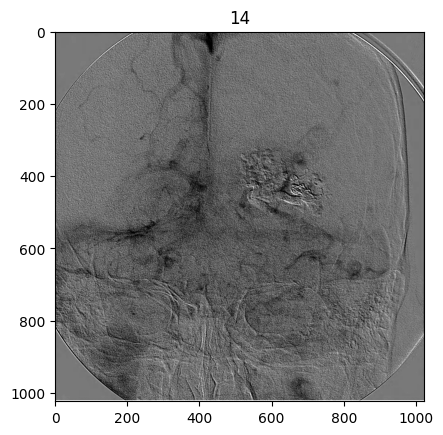

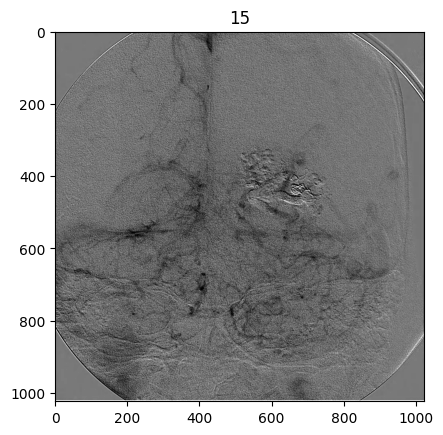

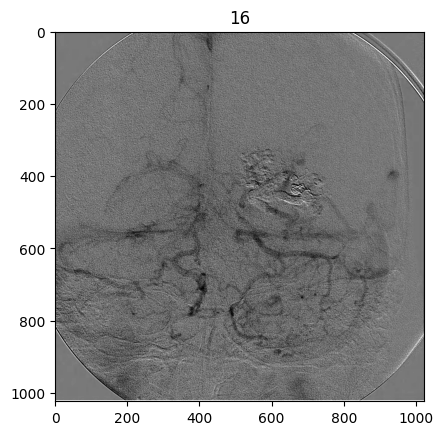

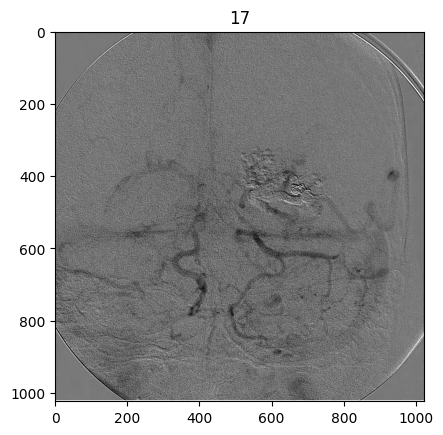

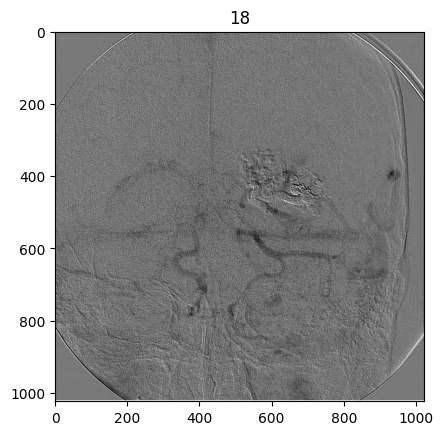

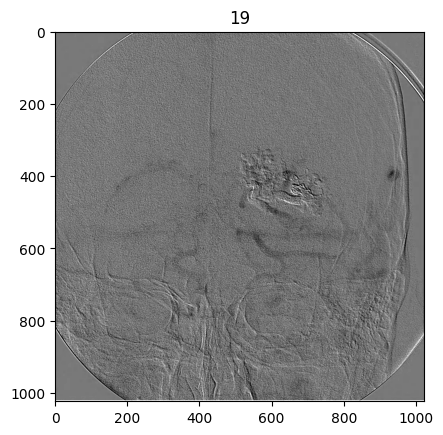

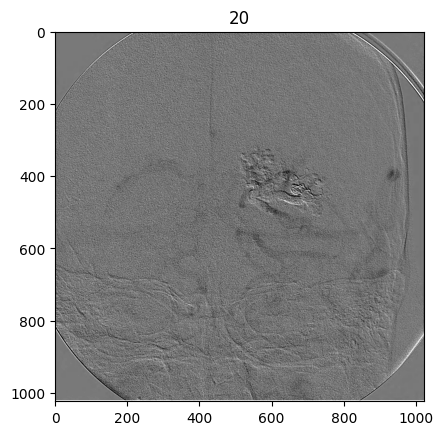

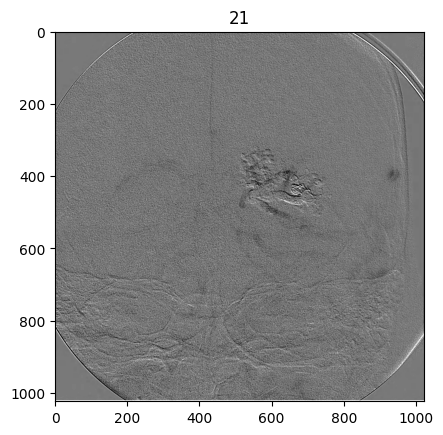

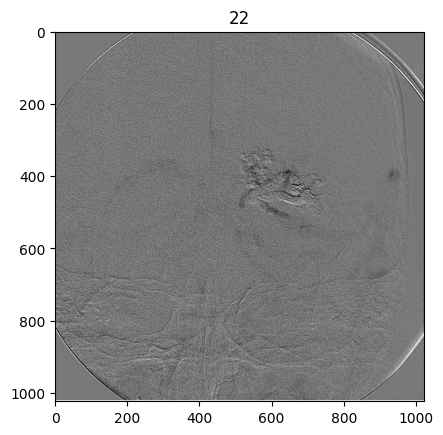

In [6]:
#"""AngioSample_Cerebr._3_fps_20040701120000_12.nii"""
w_max = 593
w_min = 417
frame_num = 0

for i in range(img_list.shape[2]):
    img = img_list[:,:,i]
    from scipy import ndimage
    img = ndimage.rotate(img, 90, reshape=False)
    img_w = 255*(img - w_min)/(w_max - w_min)
    img_w[img_w > 255] = 255 # 255より大きいところを255にする
    img_w[img_w < 0] = 0 # 0未満を0にする
    plt.title(frame_num)
    plt.imshow(img_w, cmap='gray')
    plt.show()
    cv2.imwrite(f'data/{frame_num:05}.png', img_w , )
    frame_num += 1

In [7]:
def flow_vector(flow, spacing, margin, minlength):
    """Parameters:
    input
    flow: motion vectors 3D-array
    spacing: pixel spacing of the flow
    margin: pixel margins of the flow
    minlength: minimum pixels to leave as flow
    output
    x: x coord 1D-array
    y: y coord 1D-array
    u: x direction flow vector 2D-array
    v: y direction flow vector 2D-array
    """
    h, w, _ = flow.shape

    x = np.arange(margin, w - margin, spacing, dtype=np.int64)
    y = np.arange(margin, h - margin, spacing, dtype=np.int64)

    mesh_flow = flow[np.ix_(y, x)]
    mag, _ = cv2.cartToPolar(mesh_flow[..., 0], mesh_flow[..., 1])
    mesh_flow[mag < minlength] = np.nan  # minlength以下をnanに置換

    u = mesh_flow[..., 0]
    v = mesh_flow[..., 1]

    return x, y, u, v

def adjust_ang(ang_min, ang_max):
    """Parameters
    input
    ang_min: start angle of degree
    ang_max: end angle of degree
    output
    unique_ang_min: angle after conversion to unique `ang_min`
    unique_ang_max: angle after conversion to unique `ang_max`
    """
    unique_ang_min = ang_min
    unique_ang_max = ang_max
    unique_ang_min %= 360
    unique_ang_max %= 360
    if unique_ang_min >= unique_ang_max:
        unique_ang_max += 360
    return unique_ang_min, unique_ang_max

def any_angle_only(mag, ang, ang_min, ang_max):
    """
    input
    mag: `cv2.cartToPolar` method `mag` reuslts
    ang: `cv2.cartToPolar` method `ang` reuslts
    ang_min: start angle of degree after `adjust_ang` function
    ang_max: end angle of degree after `adjust_ang` function
    output
    any_mag: array of replace any out of range `ang` with nan
    any_ang: array of replace any out of range `mag` with nan
    description
    Replace any out of range `mag` and `ang` with nan.
    """
    any_mag = np.copy(mag)
    any_ang = np.copy(ang)
    ang_min %= 360
    ang_max %= 360
    if ang_min < ang_max:
        any_mag[(ang < ang_min) | (ang_max < ang)] = np.nan
        any_ang[(ang < ang_min) | (ang_max < ang)] = np.nan
    else:
        any_mag[(ang_max < ang) & (ang < ang_min)] = np.nan
        any_ang[(ang_max < ang) & (ang < ang_min)] = np.nan
        any_ang[ang <= ang_max] += 360
    return any_mag, any_ang

def hsv_cmap(ang_min, ang_max, size):
    """
    input
    ang_min: start angle of degree after `adjust_ang` function
    ang_max: end angle of degree after `adjust_ang` function
    size: map px size
    output
    hsv_cmap_rgb: HSV color map in radial vector flow
    x, y, u, v: radial vector flow value
    x: x coord 1D-array
    y: y coord 1D-array
    u: x direction flow vector 2D-array
    v: y direction flow vector 2D-array
    description
    Create a normalized hsv colormap between `ang_min` and `ang_max`.
    """
    # 放射状に広がるベクトル場の生成
    half = size // 2
    x = np.arange(-half, half+1, 1, dtype=np.float64)
    y = np.arange(-half, half+1, 1, dtype=np.float64)
    u, v = np.meshgrid(x, y)

    # HSV色空間の配列に入れる
    hsv = np.zeros((len(y), len(x), 3), dtype='uint8')
    mag, ang = cv2.cartToPolar(u, v, angleInDegrees=True)
    any_mag, any_ang = any_angle_only(mag, ang, ang_min, ang_max)
    hsv[..., 0] = 180*(any_ang - ang_min) / (ang_max - ang_min)
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
    hsv_cmap_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return hsv_cmap_rgb, x, y, u, v

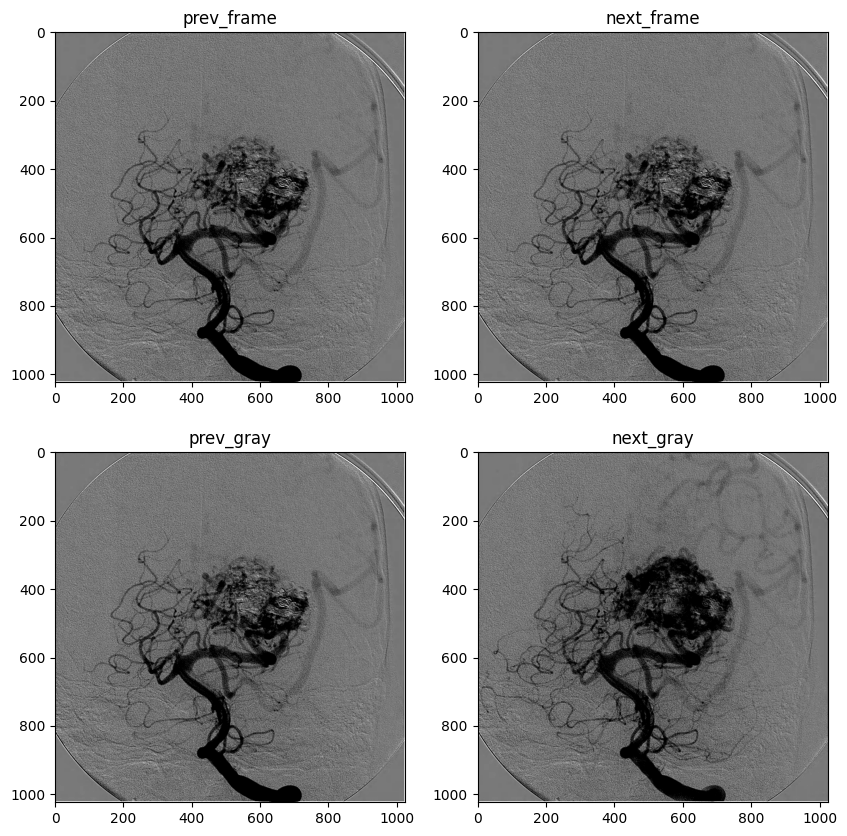

In [8]:
# フレームの読み込み
prev_frame = cv2.imread('data/00006.png')
next_frame = cv2.imread('data/00007.png')

# グレースケール化
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)

# 表示
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
prev_rgb = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB)
axs[0, 0].set_title('prev_frame')
axs[0, 0].imshow(prev_rgb)
next_rgb = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2RGB)
axs[0, 1].set_title('next_frame')
axs[0, 1].imshow(next_rgb)
axs[1, 0].set_title('prev_gray')
axs[1, 0].imshow(prev_gray, cmap='gray')
axs[1, 1].set_title('next_gray')
axs[1, 1].imshow(next_gray, cmap='gray')

plt.show()

In [9]:
# dence optical-flowの計算

flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.9, 5, 15, 3, 5, 1.2, 1)

# 2枚のフレームでの例(matplotlibで表示のみ)

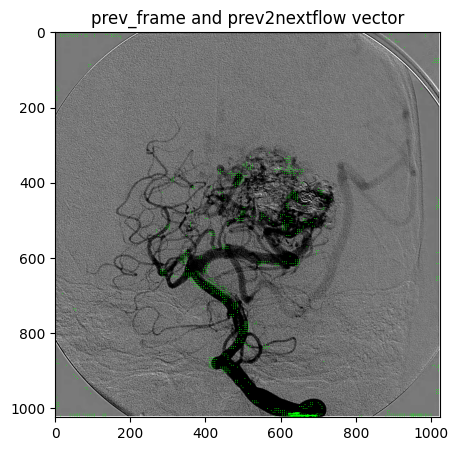

In [10]:
"""矢印で表示"""
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_title('prev_frame and prev2nextflow vector')
ax.imshow(prev_frame, cmap='gray')
x, y, u, v = flow_vector(flow=flow, spacing=5, margin=0, minlength=1)
ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color=[0.0, 1.0, 0.0])

plt.show()

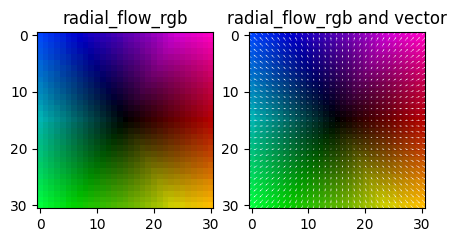

In [11]:
"""HSV色空間にベクトル場の角度に色相を、大きさに明度を対応させて表示"""
# 角度範囲のパラメータ
ang_min = 0
ang_max = 360
_ang_min, _ang_max = adjust_ang(ang_min, ang_max)  # 角度の表現を統一する

hsv_cmap_rgb, x, y, u, v = hsv_cmap(_ang_min, _ang_max, 31)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(5, 5))
ax1.set_title('radial_flow_rgb')
ax1.imshow(hsv_cmap_rgb)

ax2.imshow(hsv_cmap_rgb)
ax2.set_title('radial_flow_rgb and vector')
ax2.quiver(np.arange(len(x)), np.arange(len(y)), u, v, angles='xy', scale_units='xy', color='w')

plt.show()

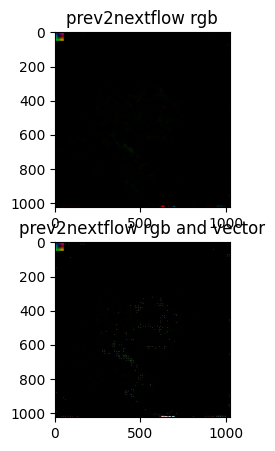

In [12]:
"""実際のflowでHSV色空間に矢印の角度に色相を、大きさに明度を対応させて表示"""
# 角度範囲のパラメータ
ang_min = 0
ang_max = 360
_ang_min, _ang_max = adjust_ang(ang_min, ang_max)  # 角度の表現を統一する

# HSV色空間の配列に入れる
hsv = np.zeros_like(prev_frame, dtype='uint8')
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
any_mag, any_ang = any_angle_only(mag, ang, ang_min, ang_max)
hsv[..., 0] = 180*(any_ang - _ang_min) / (_ang_max - _ang_min)
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# 画像の原点にHSV色空間を埋め込み
flow_rgb_display = np.copy(flow_rgb)
hsv_cmap_rgb, *_ = hsv_cmap(_ang_min, _ang_max, 51)
flow_rgb_display[0:hsv_cmap_rgb.shape[0], 0:hsv_cmap_rgb.shape[1]] = hsv_cmap_rgb

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 5))
ax1.set_title('prev2nextflow rgb')
ax1.imshow(flow_rgb_display)

ax2.imshow(flow_rgb_display)
x, y, u, v = flow_vector(flow=flow, spacing=10, margin=0, minlength=1)
ax2.set_title('prev2nextflow rgb and vector')
ax2.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='w')

plt.show()

<ipython-input-7-d509eca7dc0c>:97: RuntimeWarning: invalid value encountered in cast
  hsv[..., 0] = 180*(any_ang - ang_min) / (ang_max - ang_min)
<ipython-input-7-d509eca7dc0c>:99: RuntimeWarning: invalid value encountered in cast
  hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)


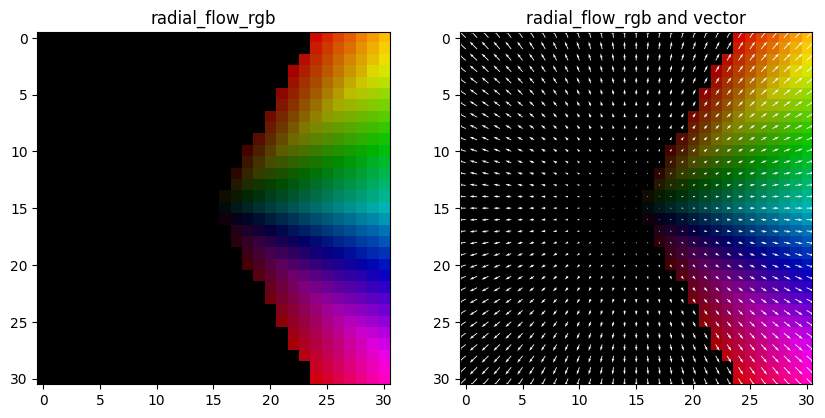

In [13]:
"""任意の角度範囲のHSV色空間にベクトル場の角度に色相を、大きさに明度を対応させて表示"""
# 角度範囲のパラメータ
ang_min = 300
ang_max = 60
_ang_min, _ang_max = adjust_ang(ang_min, ang_max)  # 角度の表現を統一する

hsv_cmap_rgb, x, y, u, v = hsv_cmap(_ang_min, _ang_max, 31)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))
ax1.set_title('radial_flow_rgb')
ax1.imshow(hsv_cmap_rgb)

ax2.imshow(hsv_cmap_rgb)
ax2.set_title('radial_flow_rgb and vector')
ax2.quiver(np.arange(len(x)), np.arange(len(y)), u, v, angles='xy', scale_units='xy', color='w')

plt.show()

<ipython-input-14-fae99817387a>:11: RuntimeWarning: invalid value encountered in cast
  hsv[..., 0] = 180*(any_ang - _ang_min) / (_ang_max - _ang_min)
<ipython-input-14-fae99817387a>:13: RuntimeWarning: invalid value encountered in cast
  hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
<ipython-input-7-d509eca7dc0c>:97: RuntimeWarning: invalid value encountered in cast
  hsv[..., 0] = 180*(any_ang - ang_min) / (ang_max - ang_min)
<ipython-input-7-d509eca7dc0c>:99: RuntimeWarning: invalid value encountered in cast
  hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)


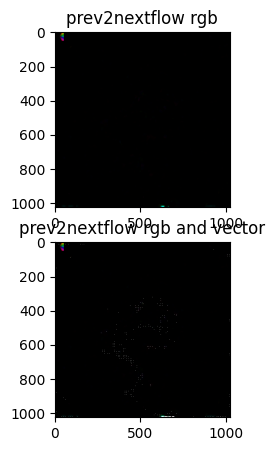

In [14]:
"""実際のflowで任意の角度範囲のHSV色空間に矢印の角度に色相を、大きさに明度を対応させて表示"""
# 角度範囲のパラメータ
ang_min = 300
ang_max = 60
_ang_min, _ang_max = adjust_ang(ang_min, ang_max)  # 角度の表現を統一する

# HSV色空間の配列に入れる
hsv = np.zeros_like(prev_frame, dtype='uint8')
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
any_mag, any_ang = any_angle_only(mag, ang, ang_min, ang_max)
hsv[..., 0] = 180*(any_ang - _ang_min) / (_ang_max - _ang_min)
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# 画像の原点にHSV色空間を埋め込み
flow_rgb_display = np.copy(flow_rgb)
hsv_cmap_rgb, *_ = hsv_cmap(_ang_min, _ang_max, 51)
flow_rgb_display[0:hsv_cmap_rgb.shape[0], 0:hsv_cmap_rgb.shape[1]] = hsv_cmap_rgb

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(5, 5))
ax1.set_title('prev2nextflow rgb')
ax1.imshow(flow_rgb_display)

ax2.imshow(flow_rgb_display)
x, y, u, v = flow_vector(flow=flow, spacing=10, margin=0, minlength=1)
ax2.set_title('prev2nextflow rgb and vector')
ax2.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='w')

plt.show()

# 補足(矢印を画像として保存)

In [15]:
def cv2_vector_display(img, color, x, y, u, v):
    """Parameters:
    input
    img: the first image used to calculate the flow
    color: 3 channels 0 to 255 color
    x, y, u, v: `flow_vector` function reuslts
    x: x coord 1D-array
    y: y coord 1D-array
    u: x direction flow vector 2D-array
    v: y direction flow vector 2D-array
    output
    flow_img: image with vector added to input `img`
    description
    Create an image with a vector added to the input `img` using cv2.
    e.g. u[j, i] is the vector of flow in the x direction at (x[i], y[j]) coord.
    """
    flow_img = np.copy(img)
    for i in range(len(x)):
        for j in range(len(y)):
            if np.isnan(u[j, i]) or np.isnan(v[j, i]):
                continue
            pts = np.array([[x[i], y[j]], [x[i]+u[j, i], y[j]+v[j, i]]], np.int64)
            cv2.arrowedLine(flow_img, pts[0], pts[1], color, thickness=1, tipLength=0.5)
    return flow_img

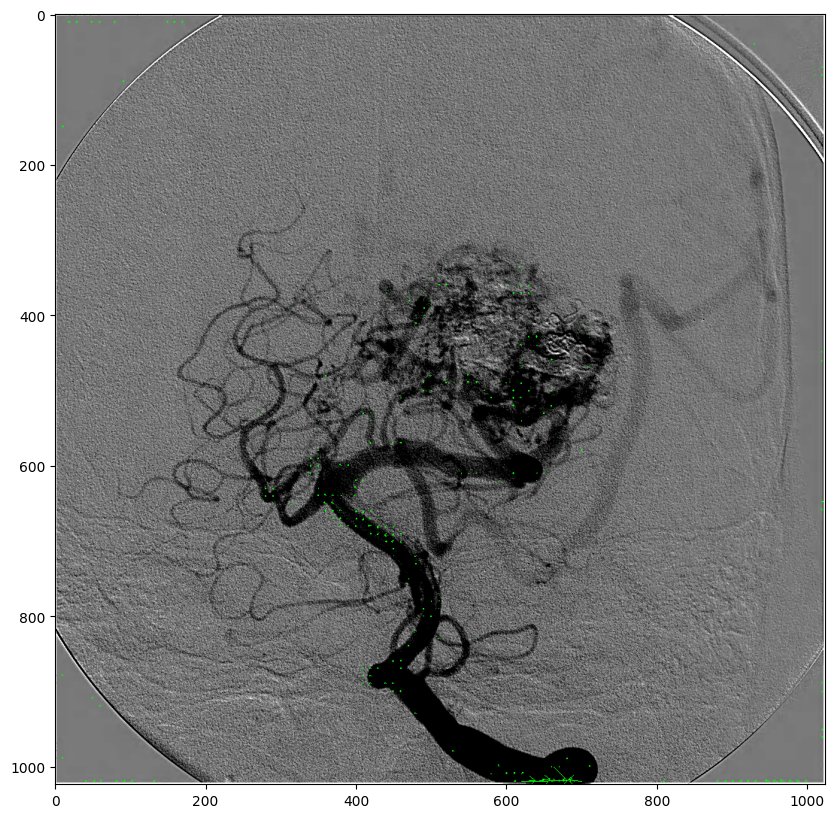

In [16]:
"""矢印付きの画像で保存"""
x, y, u, v = flow_vector(flow=flow, spacing=10, margin=0, minlength=1)
flow_img_vector = cv2_vector_display(prev_frame, (0, 255, 0), x, y, u, v)
cv2.imwrite('flow_img_vector.png', flow_img_vector)

# 保存したファイルをmatplotlibでも確認
fig, ax = plt.subplots(figsize=(10, 10))
flow_img_vector = cv2.cvtColor(flow_img_vector, cv2.COLOR_BGR2RGB)
ax.imshow(flow_img_vector)
plt.show()

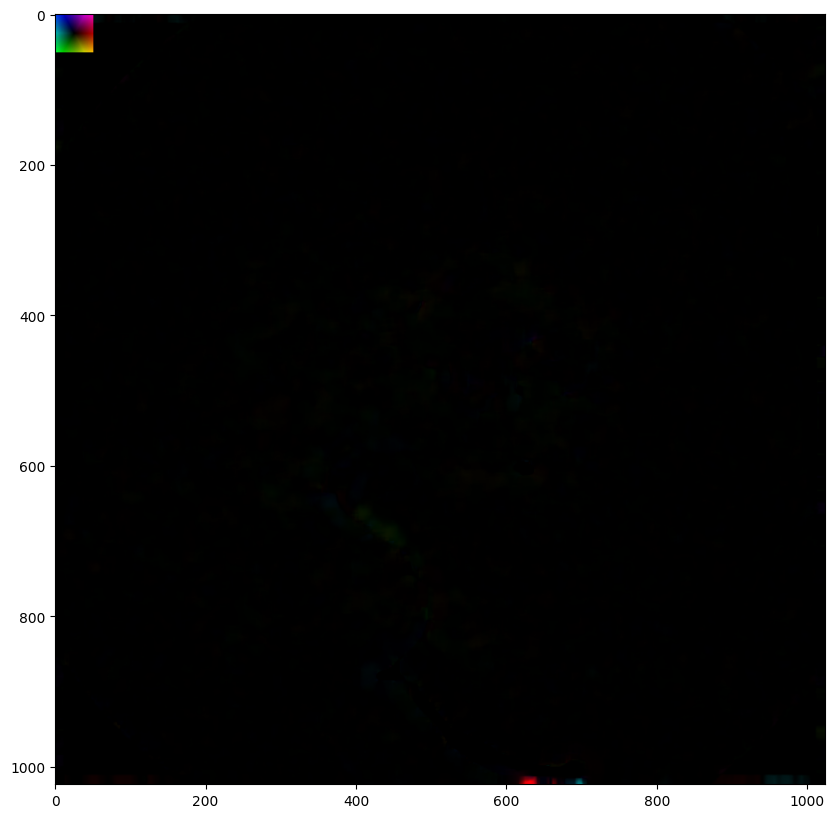

In [17]:
"""矢印をHSV色空間で表示して画像で保存"""
# 角度範囲のパラメータ
ang_min = 0
ang_max = 360
_ang_min, _ang_max = adjust_ang(ang_min, ang_max)  # 角度の表現を統一する

hsv = np.zeros_like(prev_frame, dtype='uint8')
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
any_mag, any_ang = any_angle_only(mag, ang, ang_min, ang_max)
hsv[..., 0] = 180*(any_ang - _ang_min) / (_ang_max - _ang_min)
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

# 画像の原点にHSV色空間を埋め込み
hsv_cmap_rgb, *_ = hsv_cmap(_ang_min, _ang_max, 51)
hsv_cmap_bgr = cv2.cvtColor(hsv_cmap_rgb, cv2.COLOR_RGB2BGR)
flow_bgr[0:hsv_cmap_bgr.shape[0], 0:hsv_cmap_bgr.shape[1]] = hsv_cmap_bgr
cv2.imwrite('flow_rgb.png', flow_bgr)

# 保存したファイルをmatplotlibでも確認
fig, ax = plt.subplots(figsize=(10, 10))
flow_rgb_vector = cv2.cvtColor(flow_bgr, cv2.COLOR_BGR2RGB)
ax.imshow(flow_rgb_vector)

plt.show()

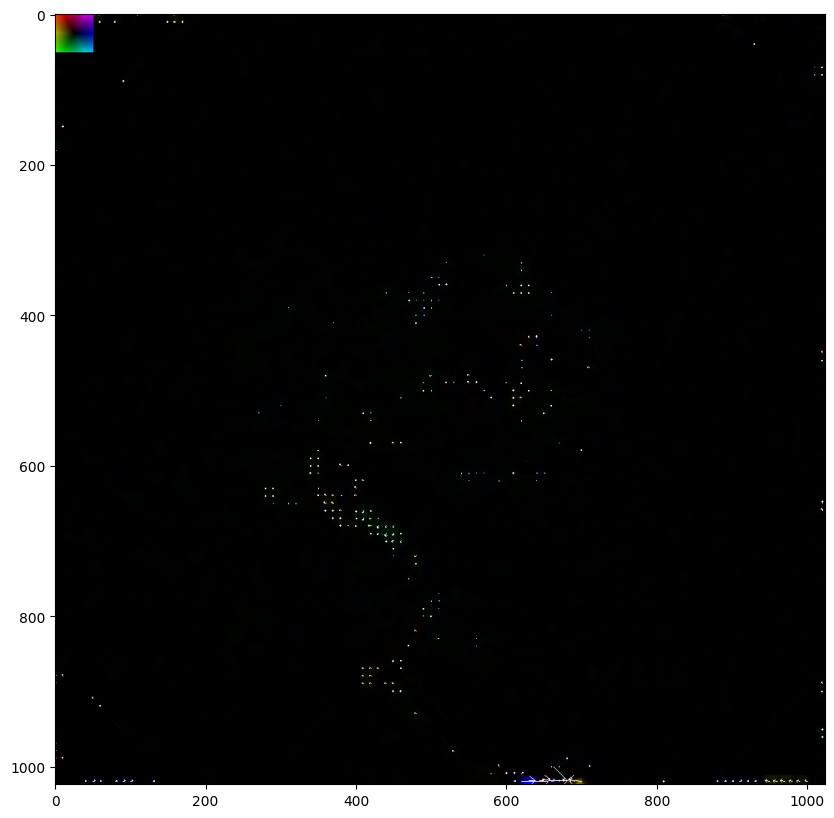

In [18]:
"""任意の角度の矢印と矢印を色の両方を表示して画像で保存"""
# 角度範囲のパラメータ
ang_min = 0
ang_max = 360
_ang_min, _ang_max = adjust_ang(ang_min, ang_max)  # 角度の表現を統一する

hsv = np.zeros_like(prev_frame, dtype='uint8')
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
any_mag, any_ang = any_angle_only(mag, ang, ang_min, ang_max)
hsv[..., 0] = 180*(any_ang - _ang_min) / (_ang_max - _ang_min)
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
flow_rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
x, y, u, v = flow_vector(flow=flow, spacing=10, margin=0, minlength=1)
flow_rgb_vector = cv2_vector_display(flow_rgb, (255, 255, 255), x, y, u, v)

# 画像の原点にHSV色空間を埋め込み
hsv_cmap_bgr, *_ = hsv_cmap(_ang_min, _ang_max, 51)
flow_rgb_vector[0:hsv_cmap_bgr.shape[0], 0:hsv_cmap_bgr.shape[1]] = hsv_cmap_bgr
cv2.imwrite('flow_rgb_vector.png', flow_rgb_vector)

# 保存したファイルをmatplotlibでも確認
fig, ax = plt.subplots(figsize=(10, 10))
flow_bgr_vector = cv2.cvtColor(flow_rgb_vector, cv2.COLOR_RGB2BGR)
ax.imshow(flow_bgr_vector)

plt.show()

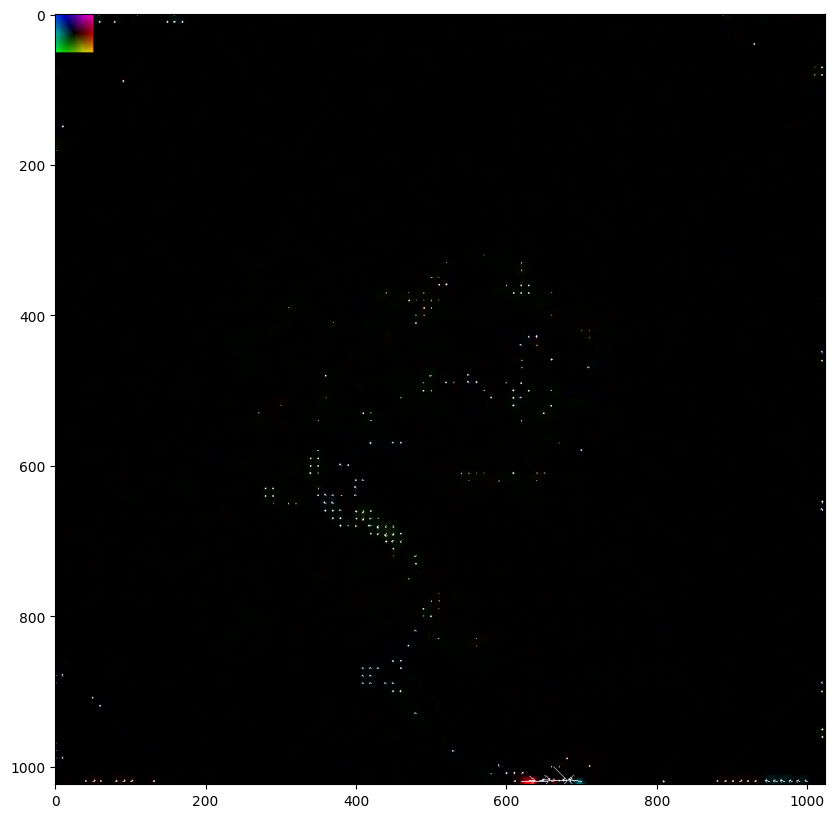

In [19]:
"""任意の角度の矢印と矢印を色の両方を表示して画像で保存"""
# 角度範囲のパラメータ
ang_min = 0
ang_max = 360
_ang_min, _ang_max = adjust_ang(ang_min, ang_max)  # 角度の表現を統一する

hsv = np.zeros_like(prev_frame, dtype='uint8')
mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1], angleInDegrees=True)
any_mag, any_ang = any_angle_only(mag, ang, ang_min, ang_max)
hsv[..., 0] = 180*(any_ang - _ang_min) / (_ang_max - _ang_min)
hsv[..., 1] = 255
hsv[..., 2] = cv2.normalize(any_mag, None, 0, 255, cv2.NORM_MINMAX)
flow_bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
x, y, u, v = flow_vector(flow=flow, spacing=10, margin=0, minlength=1)
flow_bgr_vector = cv2_vector_display(flow_bgr, (255, 255, 255), x, y, u, v)

# 画像の原点にHSV色空間を埋め込み
hsv_cmap_rgb, *_ = hsv_cmap(_ang_min, _ang_max, 51)
hsv_cmap_bgr = cv2.cvtColor(hsv_cmap_rgb, cv2.COLOR_RGB2BGR)
flow_bgr_vector[0:hsv_cmap_bgr.shape[0], 0:hsv_cmap_bgr.shape[1]] = hsv_cmap_bgr
cv2.imwrite('flow_rgb_vector.png', flow_bgr_vector)

# 保存したファイルをmatplotlibでも確認
fig, ax = plt.subplots(figsize=(10, 10))
flow_rgb_vector = cv2.cvtColor(flow_bgr_vector, cv2.COLOR_BGR2RGB)
ax.imshow(flow_rgb_vector)

plt.show()

dataフォルダ内のPNGファイルをすべて削除

In [ ]:
Delete_PNG=False #@param {type:"boolean"}
if Delete_PNG:
  print('Delete_PNG')
  import glob
  import os
  if os.path.isfile(p):
    os.remove(p)